基尼指数最小的特征作为节点

基尼指数
\begin{align*}
gini(D)  &=1-\sum_{i=1}^{m}p_i^{2}  \\
gini_A(D)&=\frac{|D_1|}{|D|}gini(D_1)+ \frac{|D_2|}{|D|}gini(D_2)\\
\Delta gini(A)&=gini(D)-gini_{A}(D)
\end{align*}

   age  income  student  credit_rating buys_computer
0    0       0        1              1            no
1    0       0        1              0            no
2    1       0        1              1           yes
3    2       1        1              1           yes
4    2       2        0              1           yes
desicionTree:
 {'age': {0: {'income': {0: 'no', 1: {'student': {0: 'yes', 1: 'no'}}, 2: 'yes'}}, 1: 'yes', 2: {'income': {0: 'no', 1: 'no', 2: {'student': {0: {'credit_rating': {0: 'yes', 1: 'yes'}}}}}}}}


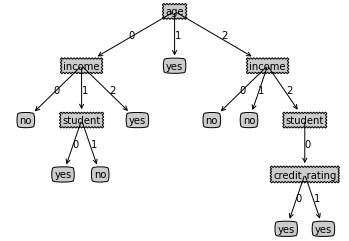

yes yes no yes yes 
['no', 'no', 'no', 'yes', 'yes']
用后划分后的test做为测试集,根据上图,可以得到准确率为:
准确率：3/5
测试数据[31...40,medium,no,fair]
['yes']


In [13]:
# -*- coding: utf-8 -*-

from math import log
import operator
import treePlotter

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# 导入决策树分类器
from sklearn.tree import DecisionTreeClassifier
# 导入分割数据集的方法
from sklearn.model_selection import train_test_split
# 导入科学计算包
import numpy as np


def calcShannonEnt(dataSet):
    """
    输入：数据集
    输出：数据集的香农熵
    描述：计算给定数据集的香农熵
    """
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt


def splitDataSet(dataSet, axis, value):
    """
    输入：数据集，选择维度，选择值
    输出：划分数据集
    描述：按照给定特征划分数据集；去除选择维度中等于选择值的项
    """
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reduceFeatVec = featVec[:axis]
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)
    return retDataSet


def chooseBestFeatureToSplit(dataSet):
    """
    输入：数据集
    输出：最好的划分维度
    描述：选择最好的数据集划分维度
    """
    numFeatures = len(dataSet[0]) - 1
    bestGini = 999999.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        uniqueVals = set(featList)
        gini = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            subProb = len(splitDataSet(subDataSet, -1, 'N')) / \
                float(len(subDataSet))
            gini += prob * (1.0 - pow(subProb, 2) - pow(1 - subProb, 2))
        if (gini < bestGini):
            bestGini = gini
            bestFeature = i
    return bestFeature


def majorityCnt(classList):
    """
    输入：分类类别列表
    输出：子节点的分类
    描述：数据集已经处理了所有属性，但是类标签依然不是唯一的，
              采用多数判决的方法决定该子节点的分类
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(),
                              key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]


def createTree(dataSet, labels):
    """
    输入：数据集，特征标签
    输出：决策树
    描述：递归构建决策树，利用上述的函数
    """
    classList = [example[-1] for example in dataSet]
    if classList.count(classList[0]) == len(classList):
        # 类别完全相同，停止划分
        return classList[0]
    if len(dataSet[0]) == 1:
        # 遍历完所有特征时返回出现次数最多的
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}
    del(labels[bestFeat])
    # 得到列表包括节点所有的属性值
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]
        myTree[bestFeatLabel][value] = createTree(
            splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree


def classify(inputTree, featLabels, testVec):
    """
    输入：决策树，分类标签，测试数据
    输出：决策结果
    描述：跑决策树
    """
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    classLabel = 'N'
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel


def classifyAll(inputTree, featLabels, testDataSet):
    """
    输入：决策树，分类标签，测试数据集
    输出：决策结果
    描述：跑决策树
    """
    classLabelAll = []
    for testVec in testDataSet:
        classLabelAll.append(classify(inputTree, featLabels, testVec))
    return classLabelAll


def storeTree(inputTree, filename):
    """
    输入：决策树，保存文件路径
    输出：
    描述：保存决策树到文件
    """
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(inputTree, fw)
    fw.close()


def grabTree(filename):
    """
    输入：文件路径名
    输出：决策树
    描述：从文件读取决策树
    """
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)


def createDataSet():

    data = pd.read_csv(
        r"C:\Users\96361\iCloudDrive\数据挖掘实践-胡仕成\B\discreteData\Sampledata-discrete.CSV", encoding='GBK')
    data["student"] = (data["student"] == "no").astype("int")
    # data["buys_computer"] = (data["buys_computer"]== "no").astype("int")
    data["credit_rating"] = (data["credit_rating"] == "fair").astype("int")
    # 将三分类变量转换为数值型变量
    labels = data["age"].unique().tolist()
    data["age"] = data["age"].apply(lambda x: labels.index(x))

    labels2 = data["income"].unique().tolist()
    data["income"] = data["income"].apply(lambda x: labels2.index(x))
    # #查看处理后的数据集
    print(data.head())


    X_train = data.iloc[:, :5].to_numpy()
    y_train = data.iloc[:, 4].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=250)

    dataSet = X_train.tolist()
    # print(dataSet,type(dataSet))
    labels = ['age', 'income', 'student', 'credit_rating']
    return dataSet, labels,X_test




def main():
    dataSet, labels ,X_test= createDataSet()
    labels_tmp = labels[:]  # 拷贝，createTree会改变labels
    desicionTree = createTree(dataSet, labels_tmp)
    print('desicionTree:\n', desicionTree)
    treePlotter.createPlot(desicionTree)
    classifyResult=classifyAll(desicionTree, labels, X_test)
    
    print("=================")
    for i in range(0,len(X_test)):
        print(X_test[i][4],end=" ")
    print()
    print(classifyResult)

    # 计算准确度
    print("用后划分后的test做为测试集,根据上图,可以得到准确率为:")
    right_count=0
    sumlen=len(X_test)
    for i in range(0,len(X_test)):
        if(X_test[i][4]==classifyResult[i]):
            right_count=right_count+1
    # print(right_count)
    print("准确率："+str(right_count)+"/"+str(sumlen))
    print("=================")
    
    print("测试数据[31...40,medium,no,fair]")
    X_test_extra=[[1,1,1,1]]
    classifyResult_extra=classifyAll(desicionTree, labels, X_test_extra)
    print(classifyResult_extra)

if __name__ == '__main__':
    main()
